# Big project

## Submission

Submit solutions to https://forms.office.com/e/WexY7YraJb.

1.   Upload code in .ipynb file
2.   Upload a csv containing three columns: 
*    "ID": the ID of the instance (1, 2, 3, ...)
*    "OBJ": the objective function value obtained
*    "TIME": the execution time in seconds.

## Evaluation

1.   Gap w.r.t. optimal solutions
2.   Runtimes. Must be under 10 minutes for every instance[" Execution times will be re-examined on a random basis.

## Deadline

12/01/2022 23:59 CET

## Other

*   4 lab points just if you deliver something that works
*   10 points based on the quality of method
*   NO pre-coded libraries, 
*   NO genetic algorithms 
*   NO neural networks
*   groups of max 3 students




## Biogas plants location

An association of $n$ farmers wants to open $p$ plants to produce energy from biogas. 
Each plant will be opened at a farm of a member of the association and will be powered with corn chopping purchased from the farm itself or from other neighboring farms.

Each farm $i$ can provide at most $c_i$ tons of corn chopping, with a percentage of dry matter $a_i$. As you may know, dry matter is the key component of corn chopping used for biogas production. In order to maintain the quality of produced energy, each plant must burn a mixture of corn chopping with a percentage of dry matter between $k_{min}$ and $k_{max}$. 

At most one plant can be located in each farm, and every farm can sell its corn chopping to one and only one plant.

Each farm $i$ is located at coordinates $x_i$ and $y_i$, representing respectively its latitude and longitude, and the cost of moving corn chopping from a farm $i$ to a farm $j$ is proportional to the euclidean distance between the two farms (it does not depend on the actual quantity moved, since the trucks used for this transportations are sufficiently big). 

Under such conditions, every plant produces $Q$ kWh of energy per ton of corn chopping burned. The energy produced by each plant will be fed into the national electricity system, at a unitary price of $b$ (€/kWh). Moreover, due to state regulations, each plant must not produce more than $M$ kWh of energy.

You must locate $p$ plants among the available farms and assign the farms that will supply each plant, with the goal of maximizing the total revenues of the association.

### Sets
*   $I$ = set of farms

### Parameters
*   $n$ = number of farms   
*   $p$ = number of plants to locate
*   $b$ = revenue per unit of energy (€/kWh)
*   $M$ = max energy production (kWh)
*   $Q$ = energy produced by a ton of corn chopping (kWh/t)
*   $k_{min} (k_{max})$ = min (max) percentage of dry matter for fermentation
*   $a_i$ = percentage of dry matter in chopping from farm $i \in I$
*   $c_i$ = tons of corn chopping available for each $i \in I$ (t)
*   $x_i, y_i$ = coordinates of farm $i \in I$

In [9]:
import json

# Reads a .json instance and returns it in a dictionary
def load_instance(filename):
  with open(filename, 'r') as f:
    data = json.load(f)
  return data

# Reads a .txt result and returns it
def load_result(filename):
  with open(filename, 'r') as f:
      result = f.read()
  return float(result)

In [8]:
import mip
import math
import numpy as np

def fast_distance_matrix(x):
    x = np.array(x)
    #
    # Inspired by: 
    # https://github.com/eth-cscs/PythonHPC/blob/master/numpy/03-euclidean-distance-matrix-numpy.ipynb
    #
    # The "Euclidean Trick" math: 
    # https://www.robots.ox.ac.uk/~albanie/notes/Euclidean_distance_trick.pdf
    #
    xy = x @ x.T
    x2 = xy.diagonal()[:,np.newaxis]
    return np.abs(x2 + x2.T - 2. * xy)**0.5

def solve(instance):
  farms = range(instance["n"])        # number of farms
  plants = range(instance["p"])       # number of plants
  corn_chopping = instance["c"]       # vector of corn chopping production for each farm
  dry_matter = instance["a"]           # vector dry matter percentage per each farm
  farm_location = instance["points"]  # vector of farm locations (x,y)
  plant_efficency = instance["Q"]     # quantity of biogas produced per each plant per each ton of corn chopped
  energy_value = instance["b"]        # energy value of biogas (€/kWh)
  max_energy = instance["M"]        # energy limit for the whole system (kWh)
  min_dry_matter = instance["kmin"]
  max_dry_matter = instance["kmax"]

  m = mip.Model(name="biogas-plant-location", sense=mip.MAXIMIZE)
  
  ## Variables ##
  # x[i][j] = 1 if plant j is located at farm i
  x = [[m.add_var(var_type=mip.BINARY) for j in farms] for i in plants]

  # y[i][j] = 1 if farm i is connected to farm j
  y = [[m.add_var(var_type=mip.BINARY) for j in farms] for i in farms]

  # sold fuel from farm i
  sold_fuel = [[m.add_var() for i in farms] for j in farms]


  ## Constraints ##
  '''
  @vector of size p
  1 if plant i is built in any location
  0 otherwise
  '''
  is_plant_build = [mip.xsum(x[i][j] for j in farms) for i in plants]

  # each plant is connected to exactly one farm
  for i in plants:
    m += is_plant_build[i] == 1

  '''
  @vector
  listing the number of plants build in each farm
  '''
  plants_in_farm = [mip.xsum(x[i][j] for i in plants) for j in farms]

  # each farm has at most one plant
  for i in farms:
    m += plants_in_farm[i] <= 1


  '''
  @vector
  1 if farm i is connected to any other farm,
    the other farm must include a plant!
  0 otherwise
  '''
  farm_farm_connections = [mip.xsum(y[i][j] for j in farms) for i in farms]
 
  # each farm sell to at most one plant
  for i in farms:
    m += farm_farm_connections[i] <= 1

  # if y_ij = 1 then x_kj = 1 for any k in plants
  for i in farms:
    for j in farms:
      m += y[i][j] <= mip.xsum(x[k][j] for k in plants)
  
  '''
  not necessary => https://webeep.polimi.it/mod/forum/discuss.php?d=57341
  # farm i sell to a plant j
  for i in farms:
    m += mip.xsum(y[i][j] for j in farms) == 1
  '''

  # fuel can be sold only to connected farms
  for i in farms:
    for j in farms:
      m += sold_fuel[i][j] <= y[i][j] * corn_chopping[i]

  # fuel constraints
  bought_fuel = [mip.xsum(sold_fuel[i][j] for i in farms) for j in farms] 
  dry_matter_in_bought_fuel = [mip.xsum(sold_fuel[i][j] * dry_matter[i] for i in farms) for j in farms]
  for i in farms:
    m += dry_matter_in_bought_fuel[i] >= min_dry_matter * bought_fuel[i]
    m += dry_matter_in_bought_fuel[i] <= max_dry_matter * bought_fuel[i]

  # energy production cannot exceed limit
  for i in farms:
    m += bought_fuel[i] * plant_efficency <= max_energy
      

  ## Objective function ##

  # sold energy!
  earnings = mip.xsum(bought_fuel[i] * plant_efficency * energy_value for i in farms)
  
  # cost of transportation from farm i to plant j
  distance = fast_distance_matrix(farm_location)

  # evaluate the distance only if is less than average
  avg_dist = np.mean(list(distance[i][j] for i in farms for j in farms))

  for i in farms:
    for j in farms:
      if(distance[i][j] > avg_dist):
        m += y[i][j] == 0


  transp_cost = mip.xsum(distance[i][j] * y[i][j] for i in farms for j in farms)

  m.objective = mip.maximize(earnings - transp_cost)

  s=0;
  while s<2:
    m.optimize()
    pair = None  # Initialize pair to None, leave the loops
    for i in farms:
        for j in plants:
            if x[j][i].x > y[j][i].x + 1e-5:
                pair = (i,j)
                break  # Leave the inner loop

        if pair != None:
            break  # Leave the outer loop if an inequality is found

    if pair == None:
        break  # No violated inequality was found, leave the loop

    i,j = pair
    m.add_constr(x[i][j] <= y[j][i])
    m.optimize()
    print(f"separated x[{i},{j}] <= y[{j}] --> new objective: {m.objective_value}")
    s+=1


  ## Optimization ##
  '''
  m.verbose = 0
  m.emphasis = 1 # FEASIBLE
  m.max_seconds = 600
  %time m.optimize(max_seconds=600)
  '''
  
  ## Output ##

  print("\nOptimization status: {}".format(m.status))
  print("Optimal solution: {}".format(m.objective_value))

  #plot the plants & farms
  plant_location = []
  for i in plants:
    for j in farms:
      if x[i][j].x == 1:
        plant_location.append(farm_location[j])
        break
  
  import matplotlib.pyplot as plt
  plt.scatter([x[0] for x in farm_location], [x[1] for x in farm_location], color='blue')
  plt.scatter([x[0] for x in plant_location], [x[1] for x in plant_location], color='red')
  
  plt.xlim(0, 100)
  plt.show()

  return m.objective_value

In [10]:
## CUTTING PLANE ALGORITHM ##
def separate(N, xstar, p, q):
    sepm = mip.Model()  # Create a new problem!
    y = [sepm.add_var(var_type=mip.BINARY) for i in N]  # This time with binary variables
    sepm.objective = mip.maximize(mip.xsum((xstar[i] - 1) * y[i] for i in N)) 
    # maximize the number of items that are not in the solution 
    # (i.e., the number of items that are in the cover inequality)
    
    sepm.add_constr(mip.xsum(p[i] * y[i] for i in N) >= q + 1) # What is this constraint? 
    sepm.optimize()
    if sepm.objective_value <= 0:  # Objective function is nonpositive ==> no violated cover inequality exists
        return None
    return [i for i in N if y[i].x > 0.5]  # check y > 0.5 for the aforementioned numerical issues


In [11]:
def test(n):
    inst = load_instance('instances/instance_'+str(n)+'.json')
    res = load_result("results/instance_"+str(n)+".txt")
    obj = solve(inst)
    print(res)

    print("error: " + str((obj - res) * 100 / res) + " %")

Cbc0038I Initial state - 0 integers unsatisfied sum - 6.66134e-16
Cbc0038I Solution found of 781976
Cbc0038I Relaxing continuous gives 781976
Cbc0038I Before mini branch and bound, 19 integers at bound fixed and 12 continuous
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)
Cbc0038I After 0.00 seconds - Feasibility pump exiting with objective of 781976 - took 0.00 seconds
Cbc0012I Integer solution of 781976.47 found by feasibility pump after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 781976.4685670498, took 0 iterations and 0 nodes (0.00 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.11022e-15
Cbc0038I Solution found of 385612
Cbc0038I Relaxing continuous gives 385612
Cbc0038I Before mini branch and bound, 76 integers at bound fixed and 56 continuous
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)
Cbc0038I After 0.00 seconds 

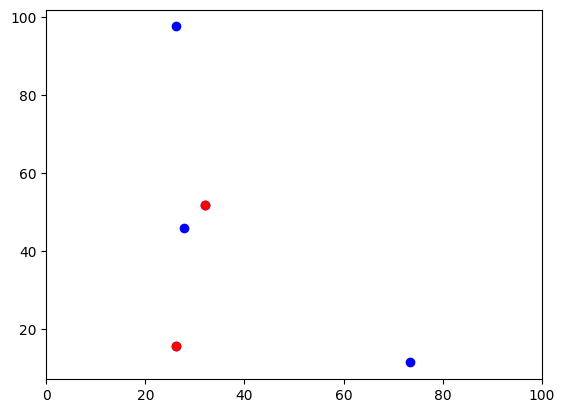

1324477.6736137536
error: -40.95963381296746 %


In [12]:
test(1)

maxSavedSolutions was changed from 1 to 10
Continuous objective value is 781976 - 5.6e-05 seconds
Cgl0002I 14 variables fixed
Cgl0008I 5 inequality constraints converted to equality constraints
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 19 rows, 21 columns (21 integer (21 of which binary)) and 67 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 7.420%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0045I MIPStart provided solution with cost 781976
Cbc0012I Integer solution of 781976.47 found by Reduced search after 0 iterations and 0 nodes (0.00 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045I Solution of 781976 already found by heuristic


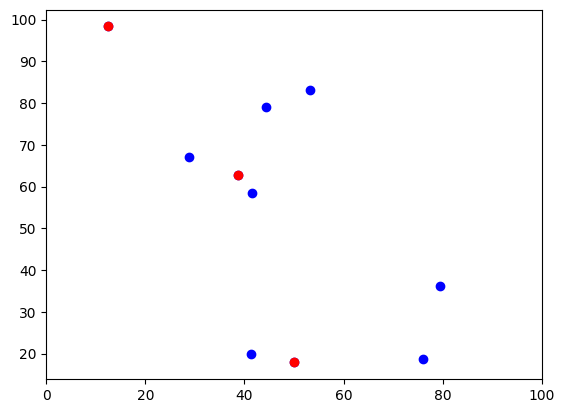

385611.91779212654
error: 0.0 %


In [13]:
test(2)

maxSavedSolutions was changed from 1 to 10
Continuous objective value is 385612 - 0.000154 seconds
Cgl0002I 54 variables fixed
Cgl0008I 10 inequality constraints converted to equality constraints
Cgl0004I processed model has 125 rows, 132 columns (86 integer (86 of which binary)) and 436 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 1.106%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0045I MIPStart provided solution with cost 385612
Cbc0012I Integer solution of 385611.92 found by Reduced search after 0 iterations and 0 nodes (0.00 seconds)
Cbc0006I The LP relaxation is infeasible or too expensive
Cbc0045I Solution of 385612 already found by heuristic
Cuts at root node changed objective from -1.79769e+308 to 1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0 seconds)
Gomory was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0 seconds)
Knapsack 

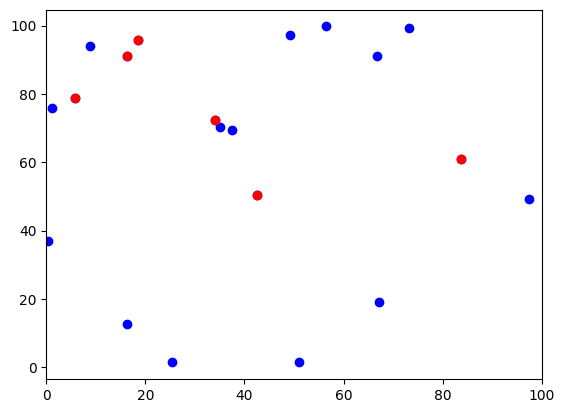

2357066.9429236925
error: -0.12699711962750884 %


In [14]:
test(3)

ng rounds of cuts (0.022869 seconds)
TwoMirCuts was tried 32 times and created 149 cuts of which 0 were active after adding rounds of cuts (0.043402 seconds)
ZeroHalf was tried 1 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.001838 seconds)

Result - Optimal solution found
Objective value:                2354073.5358
Enumerated nodes:               214422
Total iterations:               8688842
Time (CPU seconds):             601.973
Time (Wallclock seconds):       622.869
Total time (CPU seconds):       601.973   (Wallclock seconds):       622.87
Starting solution of the Linear programming relaxation problem using Dual Simplex

Coin0506I Presolve 2798 (-3702) rows, 3332 (-2468) columns and 30718 (-29616) elements
Clp0014I Perturbing problem by 0.001% of 4306.9112 - largest nonzero change 0.0010312756 ( 0.13909795%) - largest zero change 0.00043985355
Clp0006I 0  Obj -0 Primal inf 15.999984 (16) Dual inf 1504397.1 (1266)
Clp0000I Optimal - objective val

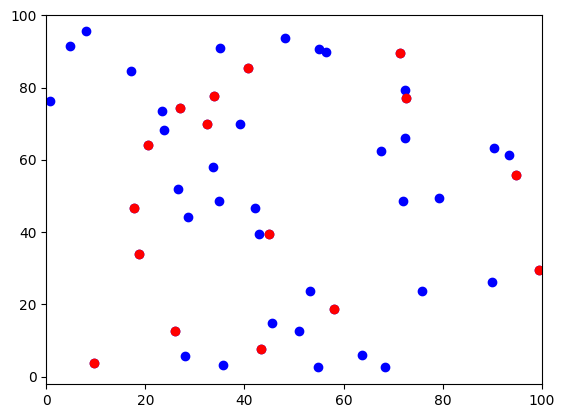

9414476.549923249
error: -0.0012509337530561262 %


In [15]:
test(4)

ee, 2354073.5 best solution, best possible 2354560.7 (541.80 seconds)
Cbc0010I After 186578 nodes, 3573 on tree, 2354073.5 best solution, best possible 2354553.3 (542.50 seconds)
Cbc0010I After 186775 nodes, 3551 on tree, 2354073.5 best solution, best possible 2354546.6 (543.20 seconds)
Cbc0010I After 187000 nodes, 3529 on tree, 2354073.5 best solution, best possible 2354539.4 (543.90 seconds)
Cbc0010I After 187226 nodes, 3505 on tree, 2354073.5 best solution, best possible 2354531.5 (544.60 seconds)
Cbc0010I After 187431 nodes, 3480 on tree, 2354073.5 best solution, best possible 2354525.1 (545.31 seconds)
Cbc0010I After 187635 nodes, 3442 on tree, 2354073.5 best solution, best possible 2354517.5 (546.01 seconds)
Cbc0010I After 187848 nodes, 3401 on tree, 2354073.5 best solution, best possible 2354509.4 (546.71 seconds)
Cbc0010I After 188055 nodes, 3364 on tree, 2354073.5 best solution, best possible 2354502 (547.41 seconds)
Cbc0010I After 188268 nodes, 3329 on tree, 2354073.5 best so

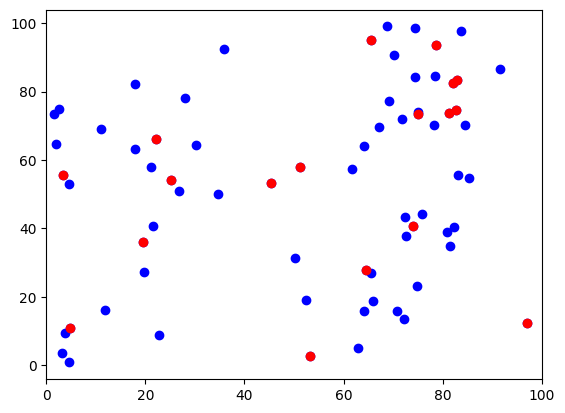

5802802.057101192

In [27]:
n = 5
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

In [28]:
n = 6
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

06
Cbc0038I Before mini branch and bound, 3458 integers at bound fixed and 2240 continuous
Cbc0038I Full problem 5096 rows 5988 columns, reduced to 377 rows 279 columns
Cbc0038I Mini branch and bound improved solution from 4.78898e+06 to 4.99051e+06 (0.78 seconds)
Cbc0038I Round again with cutoff of 5.07178e+06
Cbc0038I Pass   2: (0.87 seconds) suminf.    2.39159 (12) obj. 5.07178e+06 iterations 322
Cbc0038I Pass   3: (0.88 seconds) suminf.    2.39159 (12) obj. 5.07178e+06 iterations 1
Cbc0038I Pass   4: (0.95 seconds) suminf.    0.00000 (0) obj. 5.07178e+06 iterations 552
Cbc0038I Solution found of 5.07178e+06
Cbc0038I Relaxing continuous gives 5.34286e+06
Cbc0038I Before mini branch and bound, 3452 integers at bound fixed and 2213 continuous
Cbc0038I Full problem 5096 rows 5988 columns, reduced to 392 rows 291 columns
Cbc0038I Mini branch and bound improved solution from 5.34286e+06 to 5.36039e+06 (1.56 seconds)
Cbc0038I Freeing continuous variables gives a solution of 5.36039e+06
Cb

Cbc0020I Exiting on maximum time
Cbc0005I Partial search - best objective -1e+50 (best possible 31520873), took 0 iterations and 0 nodes (2165.51 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cbc0020I Exiting on maximum time
Cbc0005I Partial search - best objective -1e+50 (best possible 31520873), took 0 iterations and 0 nodes (3812.05 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cbc0038I Initial state - 429 integers unsatisfied sum - 121.775
Cbc0038I Pass   1: (11.07 seconds) suminf.    0.00000 (0) obj. 1.21459e+07 iterations 11486
Cbc0038I Solution found of 1.21459e+07
Cbc0038I Relaxing continuous gives 1.29492e+07
Cbc0038I Before mini branch and bound, 26562 integers at bound fixed and 22151 continuous
Cbc0038I Full problem 45780 rows 49500 columns, reduced to 988 rows 765 columns
Cbc0038I Mini branch and bound improved solution from 1.29492e+07 to 1.67267e+07 (13.89 seconds)
Cbc0038I Round again with cutoff of 1.80995e+07
Cbc0038I Pass

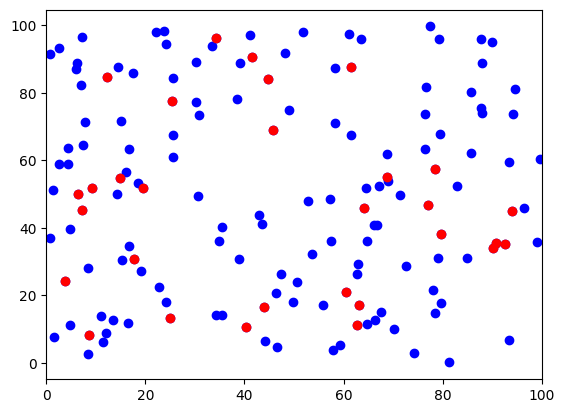

18490799.742134053

In [ ]:
n = 7
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

CPU times: user 8min 19s, sys: 10.9 s, total: 8min 30s
Wall time: 11min 48s

Optimization status: OptimizationStatus.FEASIBLE
Optimal solution: 25284593.791342467


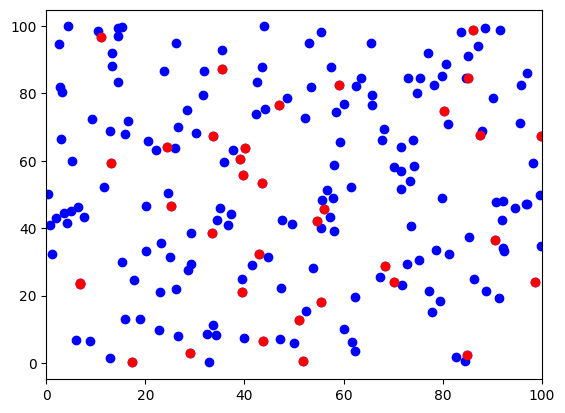

25284593.791342467

In [ ]:
n = 8
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

CPU times: user 9.05 s, sys: 309 ms, total: 9.36 s
Wall time: 9.44 s

Optimization status: OptimizationStatus.OPTIMAL
Optimal solution: 37543247.743001714


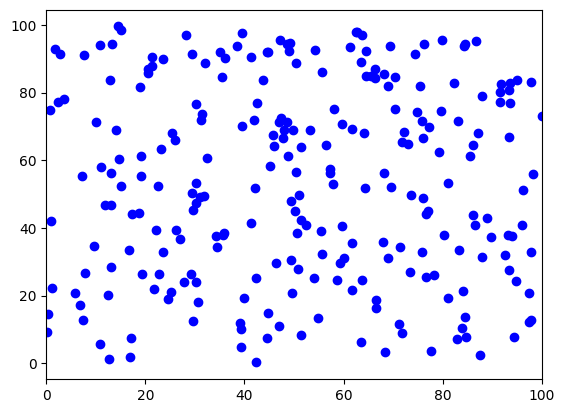

37543247.743001714

In [ ]:
n = 9
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)

CPU times: user 16min 49s, sys: 19.9 s, total: 17min 9s
Wall time: 17min 11s

Optimization status: OptimizationStatus.FEASIBLE
Optimal solution: 19767109.43776489


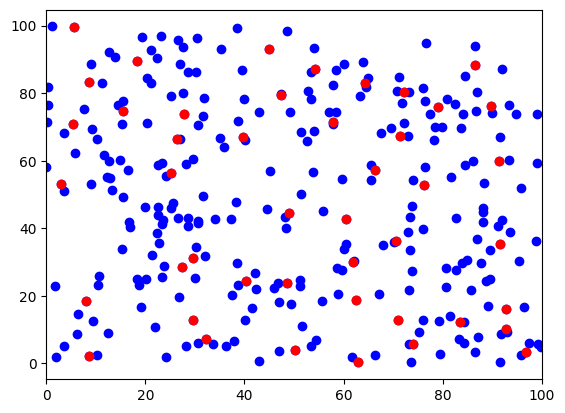

19767109.43776489

In [7]:
n = 10
inst = load_instance('instances/instance_'+str(n)+'.json')
solve(inst)